# Imports

In [9]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC




### Funktionen

In [29]:
def plot_scatter(c1: np.ndarray, c2: np.ndarray, c1_label: str, c2_label: str):
    plt.scatter(c1[:, 0], c1[:, 1], label=c1_label)
    plt.scatter(c2[:, 0], c2[:, 1], label=c2_label)
    plt.legend()
    plt.show()

def generate_dataset(c1: np.ndarray, c2: np.ndarray, test_size: float = 0.3):
    x = np.concatenate([c1, c2], axis=0)
    y = np.concatenate([np.zeros(c1.shape[0]), np.ones(c2.shape[0])], axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return x, y, x_train, x_test, y_train, y_test

def random_normal(mu, sigma, size=None, n_dim=1):
    def box_muller_transform(mu, sigma):
        u1 = random.random()
        u2 = random.random()

        z0 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        z1 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)

        return mu + z0 * sigma, mu + z1 * sigma

    def generate_n_dim_point(mu, sigma, n_dim):
        point = []
        for _ in range(n_dim // 2):
            z0, z1 = box_muller_transform(mu, sigma)
            point.extend([z0, z1])

        if n_dim % 2 == 1:
            z0, _ = box_muller_transform(mu, sigma)
            point.append(z0)

        return point

    if size is None:
        size = 1

    random_points = [generate_n_dim_point(mu, sigma, n_dim) for _ in range(size)]

    return random_points


def fit_qda(X, y):
    class0 = X[y == 0]
    class1 = X[y == 1]
    print(class0)
    n0 = class0.shape[0]
    n1 = class1.shape[0]
    N = n0 + n1

    mu0 = np.mean(class0, axis=0)
    mu1 = np.mean(class1, axis=0)

    S0 = np.dot((class0 - mu0).T, class0 - mu0)
    S1 = np.dot((class1 - mu1).T, class1 - mu1)

    S = (S0 + S1) / N

    S_inv = np.linalg.inv(S)

    W = np.dot(S_inv, mu0 - mu1)
    w0 = -0.5 * np.dot(mu0, np.dot(S_inv, mu0)) + 0.5 * np.dot(mu1, np.dot(S_inv, mu1)) + np.log(n0 / n1)

    return W, w0

def predict_qda(X, W, w0):
    return (np.dot(X, W) > w0).astype(int)


class PolynomClassification:

    def __init__(self, degree: int) -> None:
        self.degree = degree

    def fit(self,x:np.ndarray,y:np.ndarray):
        self.func =  np.poly2d(np.polyfit(x, y, deg=self.degree))
    
    def predict(self,x:np.ndarray):
        print(self.func(x))
        return self.func(x)

Size Training Data Set 1: 1400
Size Test Data Set 1: 600


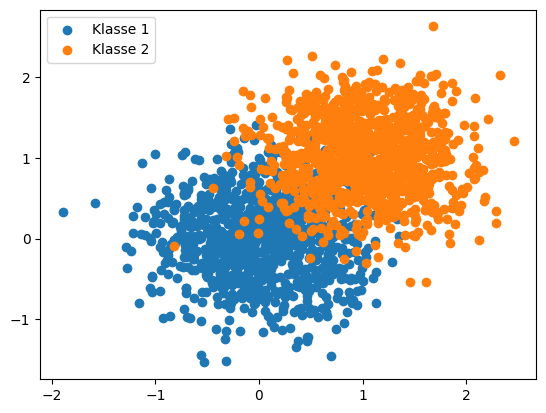

In [31]:



# Example usage:
mu = 0
sigma = 0.5
size = 1000
n_dim = 2
c1 = np.asarray(random_normal(0, sigma, size, n_dim))
c2 = np.asarray(random_normal(1, sigma, size, n_dim))

x_set1, y_set1, x_train_set1, x_test_set1, y_train_set1, y_test_set1 = generate_dataset(c1=c1, c2=c2, test_size=0.3)

print(f'Size Training Data Set 1: {x_train_set1.shape[0]}')
print(f'Size Test Data Set 1: {x_test_set1.shape[0]}')

plot_scatter(c1=c1, c2=c2, c1_label='Klasse 1', c2_label='Klasse 2')

## Polynom Klassifikator 

[[ 0.58645621  0.2707673 ]
 [-1.17371677  0.38436445]
 [-0.61375583 -0.38535385]
 ...
 [ 0.00705463  0.97596817]
 [-0.06220921  0.15156774]
 [-0.04686967 -0.103461  ]]
(2,)


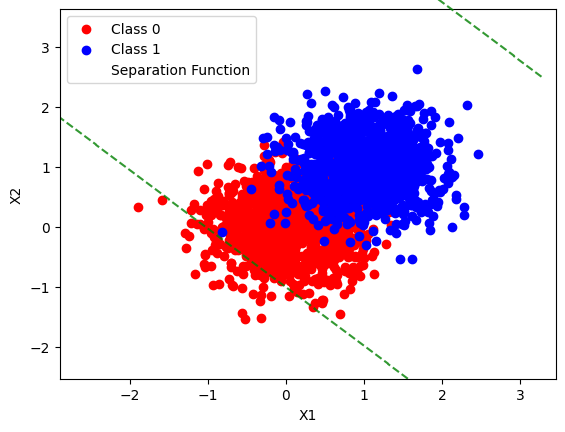

0.46166666666666667


In [36]:
W, w0 = fit_qda(x_train_set1, y_train_set1)
print(W.shape)
# Predict
y_pred = predict_qda(x_test_set1, W, w0)
fig, ax = plt.subplots()
# X = np.vstack((c1, c2))
# y = np.hstack((np.zeros(size // 2), np.ones(size // 2)))

# Plot data and separation function

# Plot class 0 and class 1 data points
ax.scatter(c1[:, 0], c1[:, 1], color='red', label='Class 0')
ax.scatter(c2[:, 0], c2[:, 1], color='blue', label='Class 1')

# Create a meshgrid for the separation function
x_min, x_max = x_set1[:, 0].min() - 1, x_set1[:, 0].max() + 1
y_min, y_max = x_set1[:, 1].min() - 1, x_set1[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, size), np.linspace(y_min, y_max, size))

# Calculate the separation function values on the meshgrid
Z = predict_qda(np.c_[xx.ravel(), yy.ravel()], W, w0)
Z = Z.reshape(xx.shape)

# Plot the separation function
contour = ax.contour(xx, yy, Z, levels=[0], colors='green', linestyles='dashed', alpha=0.8)
contour.collections[0].set_label('Separation Function')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()
plt.show()
accuracy = np.mean(y_pred == y_test_set1)
print(accuracy)

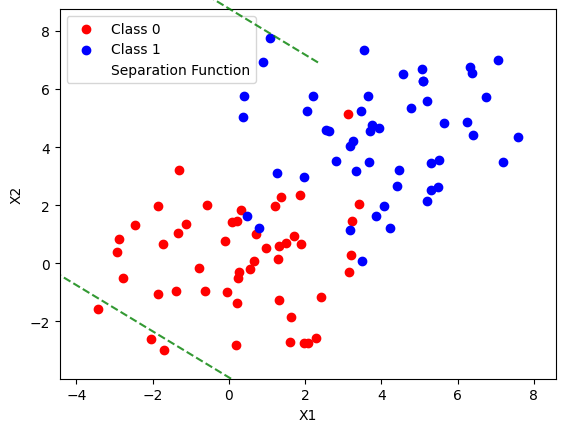

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data


X = np.vstack((class0, class1))
y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

# Fit QDA
W, w0 = fit_qda(X, y)

# Plot data and separation function
fig, ax = plt.subplots()

# Plot class 0 and class 1 data points
ax.scatter(class0[:, 0], class0[:, 1], color='red', label='Class 0')
ax.scatter(class1[:, 0], class1[:, 1], color='blue', label='Class 1')

# Create a meshgrid for the separation function
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Calculate the separation function values on the meshgrid
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) - w0
Z = Z.reshape(xx.shape)

# Plot the separation function
contour = ax.contour(xx, yy, Z, levels=[0], colors='green', linestyles='dashed', alpha=0.8)
contour.collections[0].set_label('Separation Function')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()
plt.show()

## 1. Datensatz: Unimodal teilweise überlappend

### Daten erzeugen und plotten

Size Training Data Set 1: 1400
Size Test Data Set 1: 600


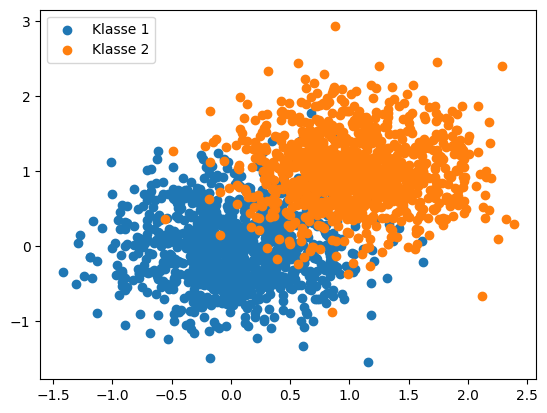

In [134]:
mean1 = [0, 0]
mean2 = [1, 1]
std = 0.5
n = 1000

c1 = np.random.normal(mean1, std, size=(n, 2))
c2 = np.random.normal(mean2, std, size=(n, 2))

x_set1, y_set1, x_train_set1, x_test_set1, y_train_set1, y_test_set1 = generate_dataset(c1=c1, c2=c2, test_size=0.3)

print(f'Size Training Data Set 1: {x_train_set1.shape[0]}')
print(f'Size Test Data Set 1: {x_test_set1.shape[0]}')

plot_scatter(c1=c1, c2=c2, c1_label='Klasse 1', c2_label='Klasse 2')

### Logistische Regression

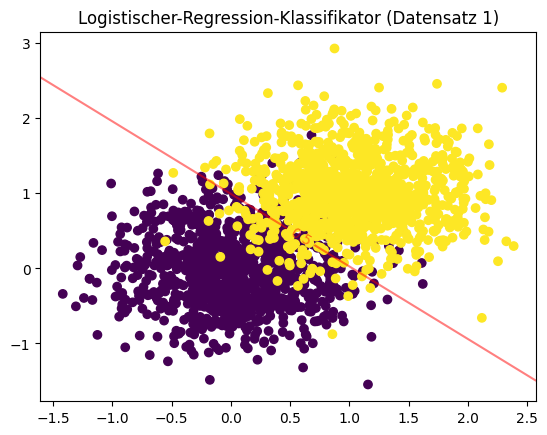

In [135]:
clf1 = LogisticRegression()
clf1.fit(x_train_set1, y_train_set1)

plt.figure()
plt.scatter(x_set1[:, 0], x_set1[:, 1], c=y_set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf1.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 1)')
plt.show()

### Fehlerwahrscheinlichkeit $ P_F $

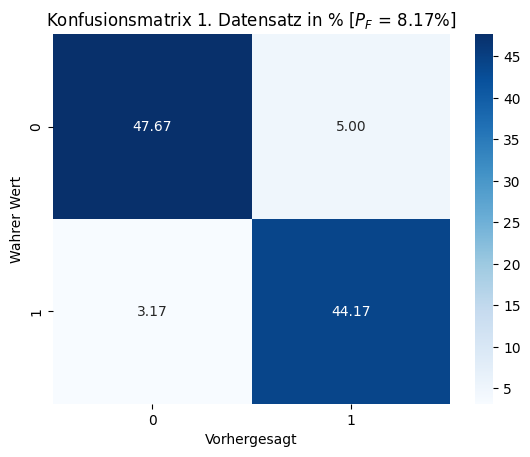

In [136]:
y_pred1 = clf1.predict(x_test_set1)

# 1. Datensatz
cm1 = confusion_matrix(y_test_set1, y_pred1)
cm_perc1 = cm1 / cm1.sum() * 100
sns.heatmap(cm_perc1, annot=True, fmt='.2f', cmap='Blues')
pf1 = (cm1[0, 1] + cm1[1, 0]) / cm1.sum() * 100
plt.xlabel('Vorhergesagt')
plt.ylabel('Wahrer Wert')
plt.title(fr'Konfusionsmatrix 1. Datensatz in % [$P_F$ = {pf1:.2f}%]')
plt.show()

### Logistische Regression mit quadratisch nichlinearer Transformation

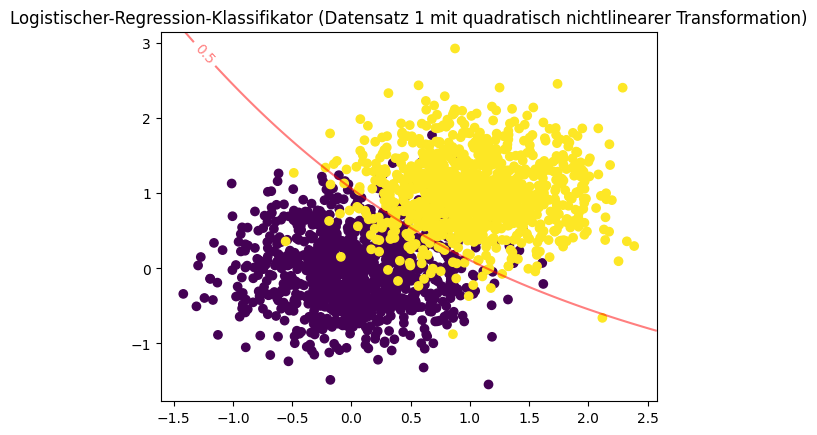

In [137]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_set1_transformed = poly.fit_transform(np.vstack([c1, c2]))

x_train_set1, x_test_set1, y_train_set1, y_test_set1 = train_test_split(x_set1_transformed, y_set1, test_size=0.3)

clf1 = LogisticRegression()
clf1.fit(x_train_set1, y_train_set1)

plt.figure()
plt.scatter(x_set1_transformed[:, 0], x_set1_transformed[:, 1], c=y_set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
xy = np.column_stack([xx.ravel(), yy.ravel()])
xy_transformed = poly.transform(xy)
Z = clf1.predict_proba(xy_transformed)[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 1 mit quadratisch nichtlinearer Transformation)')
plt.show()

### Fehlerwahrscheinlichkeit $P_F$

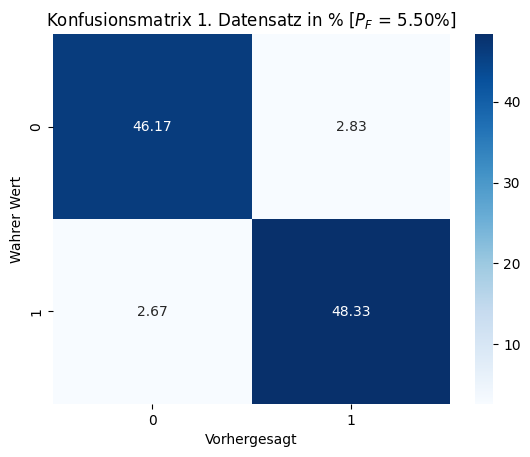

In [138]:
y_pred_set1 = clf1.predict(x_test_set1)
cm1 = confusion_matrix(y_test_set1, y_pred_set1)
cm_perc1 = cm1 / cm1.sum() * 100
pf1 = (cm1[0, 1] + cm1[1, 0]) / cm1.sum() * 100

sns.heatmap(cm_perc1, annot=True, fmt='.2f', cmap='Blues')
pf1 = (cm1[0, 1] + cm1[1, 0]) / cm1.sum() * 100
plt.xlabel('Vorhergesagt')
plt.ylabel('Wahrer Wert')
plt.title(fr'Konfusionsmatrix 1. Datensatz in % [$P_F$ = {pf1:.2f}%]')
plt.show()

## 2. Datensatz: Eine nicht unimodal verteilte Klasse

### Daten erzeugen und plotten

Size Training Data Set 2: 1400
Size Test Data Set 2: 600


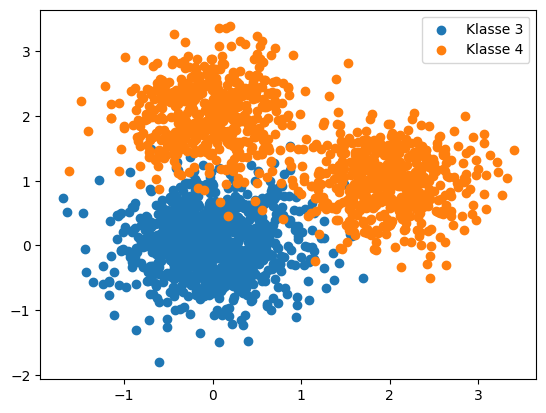

In [139]:
mean3 = [0, 0]

mean4_1 = [2, 1]
mean4_2 = [0, 2]

std = 0.5
n = 1000

c3 = np.random.normal(mean3, std, size=(n, 2))
class4_1 = np.random.normal(mean4_1, std, size=(int(n/2), 2))
class4_2 = np.random.normal(mean4_2, std, size=(int(n/2), 2))

c4 = np.concatenate([class4_1, class4_2], axis=0)

x_set2, y_set2, x_train_set2, x_test_set2, y_train_set2, y_test_set2 = generate_dataset(c1=c3, c2=c4, test_size=0.3)

print(f'Size Training Data Set 2: {x_train_set2.shape[0]}')
print(f'Size Test Data Set 2: {x_test_set2.shape[0]}')

plot_scatter(c1=c3, c2=c4, c1_label='Klasse 3', c2_label='Klasse 4')


### Logistische Regression

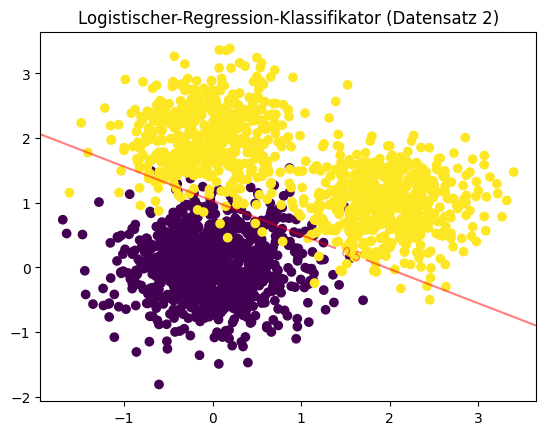

In [140]:
clf2 = LogisticRegression()
clf2.fit(x_train_set2, y_train_set2)

plt.figure()
plt.scatter(x_set2[:, 0], x_set2[:, 1], c=y_set2)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 2)')
plt.show()

### Fehlerwahrscheinlichkeit $ P_F $

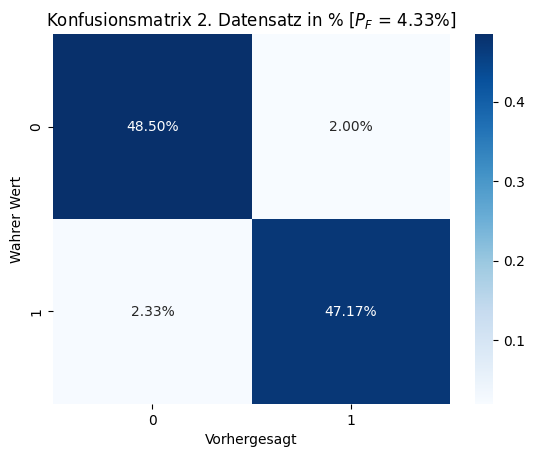

In [141]:
y_pred2 = clf2.predict(x_test_set2)

cm2 = confusion_matrix(y_test_set2, y_pred2)
cm_perc2 = cm2 / cm2.sum()

sns.heatmap(cm_perc2, annot=True, fmt='.2%', cmap='Blues')
pf2 = (cm2[0, 1] + cm2[1, 0]) / cm2.sum() * 100
plt.xlabel('Vorhergesagt')
plt.ylabel('Wahrer Wert')
plt.title(fr'Konfusionsmatrix 2. Datensatz in % [$P_F$ = {pf2:.2f}%]')
plt.show()

### Logistische Regression mit quadratisch nichlinearer Transformation

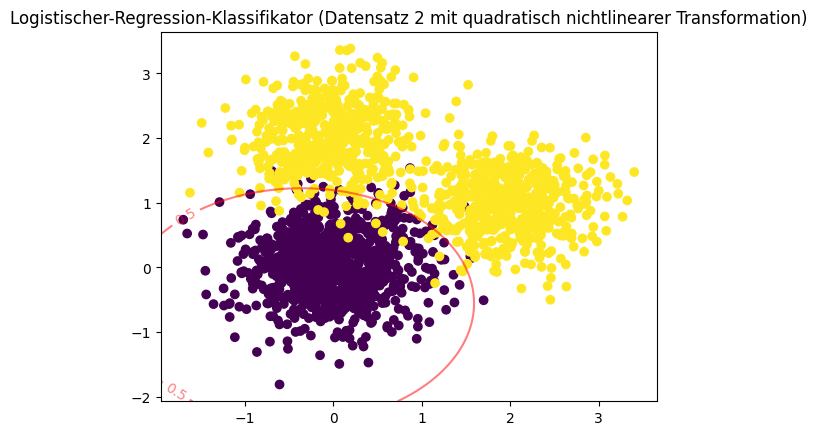

In [142]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_set2_transformed = poly.fit_transform(np.vstack([c3, c4]))

x_train_set2, x_test_set2, y_train_set2, y_test_set2 = train_test_split(x_set2_transformed, y_set2, test_size=0.3)

clf2 = LogisticRegression()
clf2.fit(x_train_set2, y_train_set2)

plt.figure()
plt.scatter(x_set2_transformed[:, 0], x_set2_transformed[:, 1], c=y_set2)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
xy = np.column_stack([xx.ravel(), yy.ravel()])
xy_transformed = poly.transform(xy)
Z = clf2.predict_proba(xy_transformed)[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 2 mit quadratisch nichtlinearer Transformation)')
plt.show()

### Fehlerwahrscheinlihckeit $P_F$

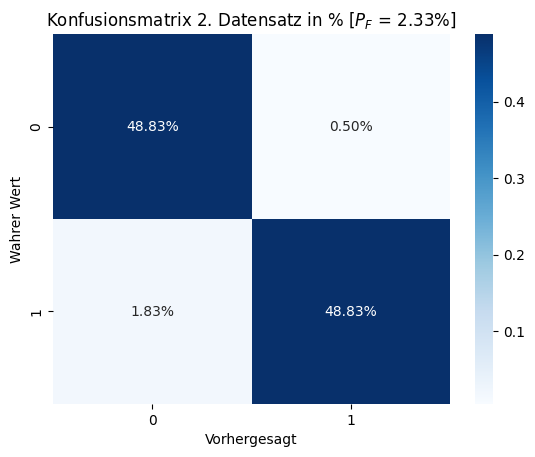

In [143]:
y_pred_set2 = clf2.predict(x_test_set2)
cm2 = confusion_matrix(y_test_set2, y_pred_set2)
cm_perc2 = cm2 / cm2.sum()

pf2 = (cm2[0, 1] + cm2[1, 0]) / cm2.sum() * 100

sns.heatmap(cm_perc2, annot=True, fmt='.2%', cmap='Blues')

plt.xlabel('Vorhergesagt')
plt.ylabel('Wahrer Wert')
plt.title(fr'Konfusionsmatrix 2. Datensatz in % [$P_F$ = {pf2:.2f}%]')
plt.show()

## Wie werden die Parameter über eine Optimierung bestimmt?

Die Parameter einer logistischen Regression werden über eine Optimierung bestimmt, indem die negativ logarithmierte Likelihood-Funktion numerisch minimiert wird.

Dies geschieht in der Regel mit Hilfe von Optimierungsalgorithmen, die den Gradienten der Funktion nutzen, um die Richtung der Parameteraktualisierung zu bestimmen. Ein weit verbreiteter Algorithmus ist zum Beispiel der Gradientenabstieg. Dabei wird ein Anfangswert für die Parameter festgelegt und iterativ so angepasst, dass die negativ logarithmierte Likelihood-Funktion minimiert wird. Die Iterationen werden fortgesetzt, bis ein Abbruchkriterium erreicht ist oder eine vorgegebene Anzahl von Iterationen durchgeführt wurde.

Ziel ist es, die Parameter so zu bestimmen, dass die Wahrscheinlichkeit, die beobachteten Daten zu erklären, maximiert wird. Dies bedeutet, dass das Modell in der Lage ist, die Beziehung zwischen den Eingangsdaten und den Zielvariablen so gut wie möglich zu modellieren und damit eine Vorhersage für neue, unbekannte Datenpunkte machen kann.